In [1]:
! mkdir -p ~/aiffel/coarse_to_fine/images

In [1]:
! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -P ~/aiffel/coarse_to_fine/models/
! cd ~/aiffel/coarse_to_fine/models/ && bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2020-12-05 12:17:06--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘/home/aiffel/aiffel/coarse_to_fine/models/shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M   404KB/s    in 3m 40s  

2020-12-05 12:20:48 (284 KB/s) - ‘/home/aiffel/aiffel/coarse_to_fine/models/shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [2]:
import matplotlib.pylab as plt
import tensorflow as tf
import os
from os.path import join
from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import math
import dlib

(347, 260, 3)


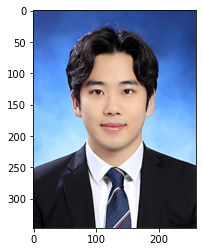

In [4]:
import os
img_path = os.getenv('HOME')+'/aiffel/coarse_to_fine/images/KimChanghee.jpg'
img = cv2.imread(img_path)
print (img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

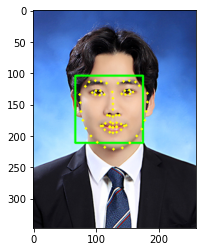

In [5]:
img_bgr = img.copy()

detector_hog = dlib.get_frontal_face_detector() # detector 선언
dlib_model_path = os.getenv('HOME')+'/aiffel/coarse_to_fine/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(dlib_model_path)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # (image, num of img pyramid)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_rgb, point, 2, (255, 255, 0), -1) # yellow

plt.imshow(img_rgb)
plt.show()

### Landmark 정보
https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/

In [6]:
def eye_crop(bgr_img, landmark):
    # dlib eye landmark: 36~41 (6), 42~47 (6)
    np_left_eye_points = np.array(landmark[36:42])
    np_right_eye_points = np.array(landmark[42:48])

    np_left_tl = np_left_eye_points.min(axis=0)
    np_left_br = np_left_eye_points.max(axis=0)
    np_right_tl = np_right_eye_points.min(axis=0)
    np_right_br = np_right_eye_points.max(axis=0)

    list_left_tl = np_left_tl.tolist()
    list_left_br = np_left_br.tolist()
    list_right_tl = np_right_tl.tolist()
    list_right_br = np_right_br.tolist()
    
    left_eye_size = np_left_br - np_left_tl
    right_eye_size = np_right_br - np_right_tl
    
    ### if eye size is small
    if left_eye_size[1] < 5:
        margin = 1
    else:
        margin = 6
    
    img_left_eye = bgr_img[np_left_tl[1]-margin:np_left_br[1]+margin, np_left_tl[0]-margin//2:np_left_br[0]+margin//2]
    img_right_eye = bgr_img[np_right_tl[1]-margin:np_right_br[1]+margin, np_right_tl[0]-margin//2:np_right_br[0]+margin//2]

    return [img_left_eye, img_right_eye]

(19, 25, 3)


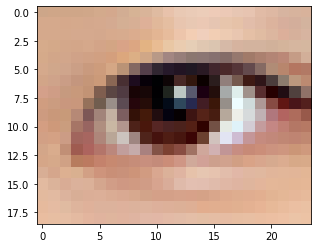

In [7]:
img_left_eye, img_right_eye = eye_crop(img_bgr, list_landmarks[0])

print (img_left_eye.shape)
plt.imshow(cv2.cvtColor(img_right_eye, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
def findCenterPoint(gray_eye, str_direction='left'):
    if gray_eye is None:
        return [0, 0]

    # smoothing
    filtered_eye = cv2.bilateralFilter(gray_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)

    # 2D images -> 1D signals
    row_sum = 255 - np.sum(filtered_eye, axis=0)//gray_eye.shape[0]
    col_sum = 255 - np.sum(filtered_eye, axis=1)//gray_eye.shape[1]

    # normalization & stabilization
    def vector_normalization(vector):
        vector = vector.astype(np.float32)
        vector = (vector-vector.min())/(vector.max()-vector.min()+1e-6)*255
        vector = vector.astype(np.uint8)
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))            
        return vector
    row_sum = vector_normalization(row_sum)
    col_sum = vector_normalization(col_sum)

    def findOptimalCenter(gray_eye, vector, str_axis='x'):
        axis = 1 if str_axis == 'x' else 0
        center_from_start = np.argmax(vector)
        center_from_end = gray_eye.shape[axis]-1 - np.argmax(np.flip(vector,axis=0))
        return (center_from_end + center_from_start) // 2

    center_x = findOptimalCenter(gray_eye, row_sum, 'x')
    center_y = findOptimalCenter(gray_eye, col_sum, 'y')

    inv_eye = (255 - filtered_eye).astype(np.float32)
    inv_eye = (255*(inv_eye - inv_eye.min())/(inv_eye.max()-inv_eye.min())).astype(np.uint8)

    resized_inv_eye = cv2.resize(inv_eye, (inv_eye.shape[1]//3, inv_eye.shape[0]//3))
    init_point = np.unravel_index(np.argmax(resized_inv_eye),resized_inv_eye.shape)

    x_candidate = init_point[1]*3 + 1
    for idx in range(10):
        temp_sum = row_sum[x_candidate-2:x_candidate+3].sum()
        if temp_sum == 0:
            break
        normalized_row_sum_part = row_sum[x_candidate-2:x_candidate+3].astype(np.float32)//temp_sum
        moving_factor = normalized_row_sum_part[3:5].sum() - normalized_row_sum_part[0:2].sum()
        if moving_factor > 0.0:
            x_candidate += 1
        elif moving_factor < 0.0:
            x_candidate -= 1
    
    center_x = x_candidate

    if center_x >= gray_eye.shape[1]-2 or center_x <= 2:
        center_x = -1
    elif center_y >= gray_eye.shape[0]-1 or center_y <= 1:
        center_y = -1
    
    return [center_x, center_y]

In [9]:
def detectPupil(bgr_img, landmark):
    if landmark is None:
        return

    img_eyes = []
    img_eyes = eye_crop(bgr_img, landmark)

    gray_left_eye = cv2.cvtColor(img_eyes[0], cv2.COLOR_BGR2GRAY)
    gray_right_eye = cv2.cvtColor(img_eyes[1], cv2.COLOR_BGR2GRAY)

    if gray_left_eye is None or gray_right_eye is None:
        return 

    left_center_x, left_center_y = findCenterPoint(gray_left_eye,'left')
    right_center_x, right_center_y = findCenterPoint(gray_right_eye,'right')

    return [left_center_x, left_center_y, right_center_x, right_center_y, gray_left_eye.shape, gray_right_eye.shape]

In [10]:
left_center_x, left_center_y, right_center_x, right_center_y, le_shape, re_shape = detectPupil(img_bgr, list_landmarks[0])
print ((left_center_x, left_center_y), (right_center_x, right_center_y), le_shape, re_shape)

(13, 7) (10, 7) (19, 25) (19, 24)


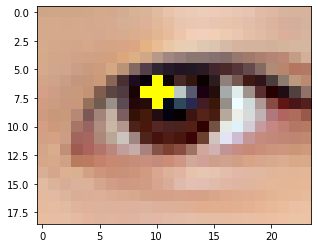

In [13]:
show = img_right_eye.copy()
    
show = cv2.circle(show, (right_center_x, right_center_y), 1, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

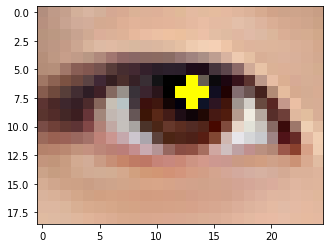

In [14]:
show = img_left_eye.copy()
    
show = cv2.circle(show, (left_center_x, left_center_y), 1, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

### Tensorflow Hub에서 Pretrained Model 불러오기
https://tfhub.dev/ml-kit/collections/image-classification/1

In [16]:
 !pip install tensorflow_hub # 설치되어 있지 않은 경우 주석 해제
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

     |████████████████████████████████| 107 kB 902 kB/s eta 0:00:01
You should consider upgrading via the '/home/aiffel/anaconda3/envs/aiffel/bin/python -m pip install --upgrade pip' command.


## RestNet이 VGG보다 좋은 이유 : 
skip connection을 통해 불필요한 파라미터를 줄일 수 있는 효과를 얻음. 불필요한 파라미터인지도 직접 학습할 수 있는 end-to-end 구조와 skip connection, 3x3 conv 의 앙상블 효과가 성능에 긍정적인 영향을 미침

In [17]:
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(80,120,3))

In [18]:
num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


## Annotation Tool
#### Object Detection : https://github.com/opencv/cvat
#### Key point Labeling & COCO type save :   https://github.com/NaturalIntelligence/imglab
https://cocodataset.org/#home

그외
labeling tool 1 : https://github.com/tzutalin/labelImg    
2 : https://github.com/wkentaro/labelme

### Anootation Tool 제작기 : https://blog.linewalks.com/archives/6240

In [22]:
! cd ~/aiffel/coarse_to_fine && python my_labeler_1st.py [imgpath or dir] [mask path or dir]

usage: my_labeler_1st.py [-h] [img_path] [mask_path]
my_labeler_1st.py: error: unrecognized arguments: dir] [mask path or dir]


In [21]:
import os
from os.path import join
from glob import glob
import cv2
import numpy as numpy
import argparse
import numpy as np
import json
from pprint import pprint

args = argparse.ArgumentParser()

# hyperparameters
args.add_argument('img_path', type=str, nargs='?', default=None)
args.add_argument('mask_path', type=str, nargs='?', default=None)

config = args.parse_args()

usage: ipykernel_launcher.py [-h] [img_path] [mask_path]
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
